In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

import env

pd.options.display.float_format = '{:20,.2f}'.format

## Acquire

In [2]:
def get_mall_data():
    url = env.get_db_url('mall_customers')
    query = 'SELECT * from customers'
    
    df = pd.read_sql(query, url)
    
    return df.set_index('customer_id')

In [3]:
df = get_mall_data()

In [4]:
df

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


## Prepare

In [5]:
df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']

In [6]:
df

,gender,age,annual_income,spending_score,is_male
customer_id,,,,,
1,Male,19,15,39,1
2,Male,21,15,81,1
3,Female,20,16,6,0
4,Female,23,16,77,0
5,Female,31,17,40,0
...,...,...,...,...,...
196,Female,35,120,79,0
197,Female,45,126,28,0
198,Male,32,126,74,1


### Summarize

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
 4   is_male         200 non-null    uint8 
dtypes: int64(3), object(1), uint8(1)
memory usage: 8.0+ KB


In [8]:
df.describe()

,age,annual_income,spending_score,is_male
count,200.00,200.00,200.00,200.00
mean,38.85,60.56,50.20,0.44
std,13.97,26.26,25.82,0.50
min,18.00,15.00,1.00,0.00
25%,28.75,41.50,34.75,0.00
50%,36.00,61.50,50.00,0.00
75%,49.00,78.00,73.00,1.00
max,70.00,137.00,99.00,1.00


In [9]:
# split test off, 20% of original df size. 
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=42)

# split validate off, 30% of what remains (24% of original df size)
# thus train will be 56% of original df size. 
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=42)

print("train observations: ", train.shape[0])
print("validate observations: ", validate.shape[0])
print("test observations: ", test.shape[0])

train observations:  112
validate observations:  48
test observations:  40


## Explore

### 1. What is the distribution of each variable?

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'annual_income'}>],
       [<AxesSubplot:title={'center':'spending_score'}>,
        <AxesSubplot:title={'center':'is_male'}>]], dtype=object)

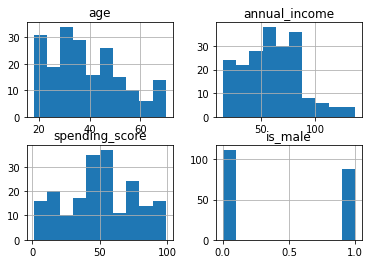

In [10]:
df.hist()

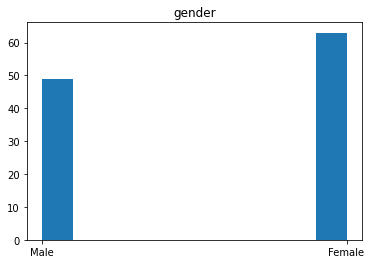

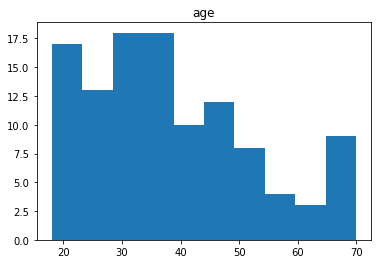

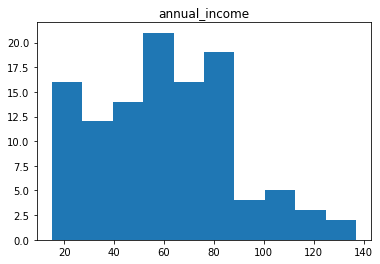

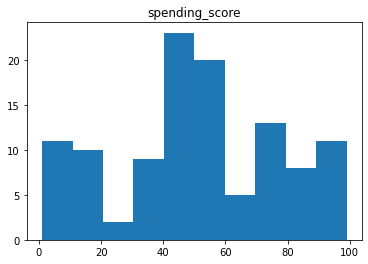

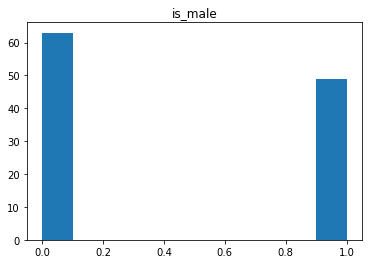

In [11]:
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### 2. Does spending_score differ across gender?

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

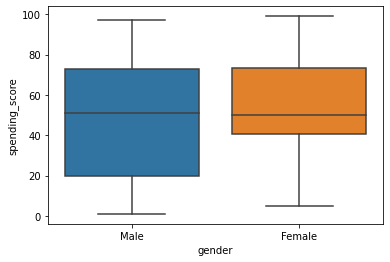

In [13]:
sns.boxplot(data=train, x='gender', y='spending_score')

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

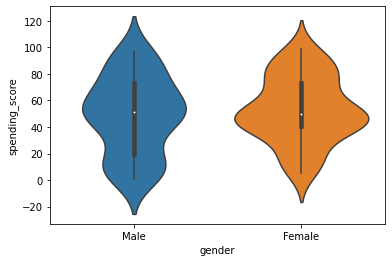

In [14]:
sns.violinplot(data=train, x='gender', y='spending_score')

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

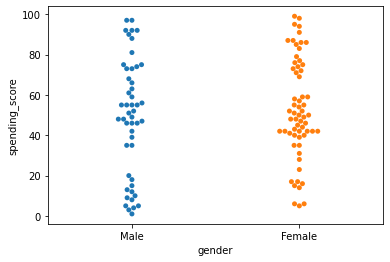

In [15]:
sns.swarmplot(data=train, x='gender', y='spending_score')

### 3. Is there a relationship between spending score and annual income?

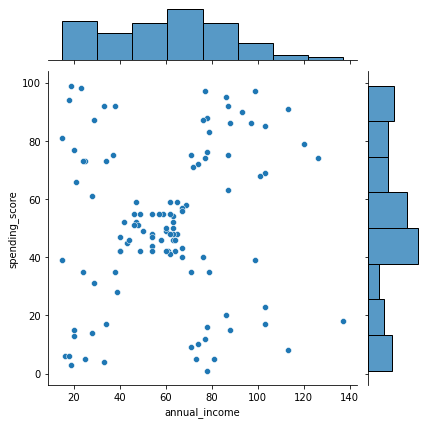

In [16]:
sns.jointplot(x='annual_income', y='spending_score', data=train)

### Is there a realationship between age and spending_score?

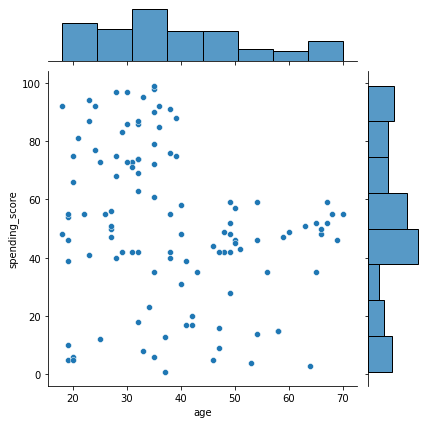

In [17]:
sns.jointplot(x='age', y='spending_score', data=train)

In [19]:
train['age_bin'] = pd.cut(train.age, [0, 40, 80])
train

,gender,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,,
131,Male,47,71,9,1,"(40, 80]"
63,Female,67,47,52,0,"(40, 80]"
14,Female,24,20,77,0,"(0, 40]"
174,Male,36,87,92,1,"(0, 40]"
145,Male,25,77,12,1,"(0, 40]"
...,...,...,...,...,...,...
1,Male,19,15,39,1,"(0, 40]"
8,Female,23,18,94,0,"(0, 40]"
118,Female,49,65,59,0,"(40, 80]"


<AxesSubplot:xlabel='age_bin', ylabel='spending_score'>

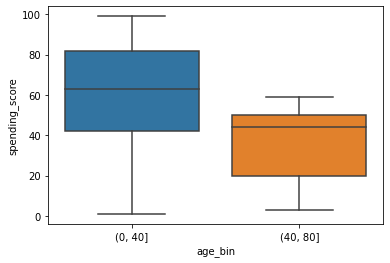

In [20]:
sns.boxplot(x=train.age_bin, y=train.spending_score)

In [21]:
stats.levene(
    train[train.age <= 40].spending_score,
    train[train.age > 40].spending_score
)

LeveneResult(statistic=11.809551017293076, pvalue=0.0008325687159373646)

In [22]:
stats.ttest_ind(
    train[train.age <= 40].spending_score,
    train[train.age > 40].spending_score,
    equal_var=False
)

Ttest_indResult(statistic=5.011777953183408, pvalue=2.087595446622472e-06)

### 5. If we control for age, does spending_score differ across annual_income?

<AxesSubplot:xlabel='annual_income', ylabel='spending_score'>

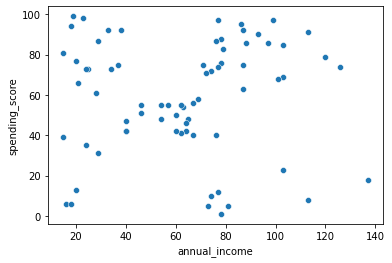

In [23]:
sns.scatterplot(x='annual_income', y='spending_score', data=train[train.age <= 40])

<AxesSubplot:xlabel='annual_income', ylabel='spending_score'>

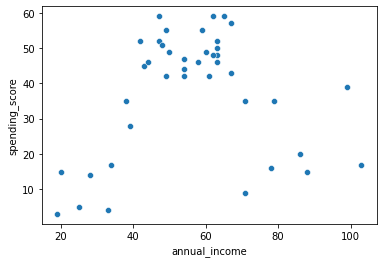

In [24]:
sns.scatterplot(x='annual_income', y='spending_score', data=train[train.age > 40])

<AxesSubplot:xlabel='annual_income', ylabel='spending_score'>

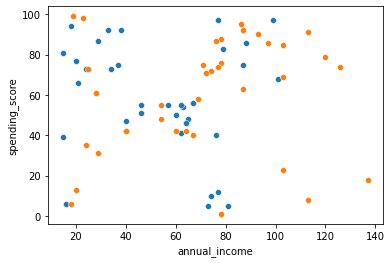

In [25]:
sns.scatterplot(x='annual_income', y='spending_score', data=train[train.age <= 30])
sns.scatterplot(x='annual_income', y='spending_score', data=train[(train.age > 30) & (train.age <=40)] )

### 6. If we control for annual income, does spending score differ across age?

In [27]:
train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 140])
train

,gender,age,annual_income,spending_score,is_male,age_bin,income_bin
customer_id,,,,,,,
131,Male,47,71,9,1,"(40, 80]","(70, 140]"
63,Female,67,47,52,0,"(40, 80]","(40, 70]"
14,Female,24,20,77,0,"(0, 40]","(0, 40]"
174,Male,36,87,92,1,"(0, 40]","(70, 140]"
145,Male,25,77,12,1,"(0, 40]","(70, 140]"
...,...,...,...,...,...,...,...
1,Male,19,15,39,1,"(0, 40]","(0, 40]"
8,Female,23,18,94,0,"(0, 40]","(0, 40]"
118,Female,49,65,59,0,"(40, 80]","(40, 70]"


<AxesSubplot:xlabel='age', ylabel='spending_score'>

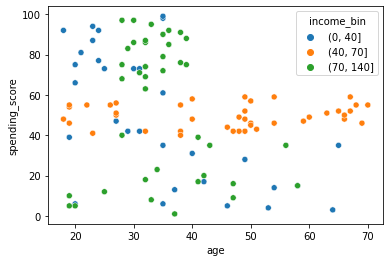

In [28]:
sns.scatterplot(x='age', y='spending_score', data=train, hue='income_bin')

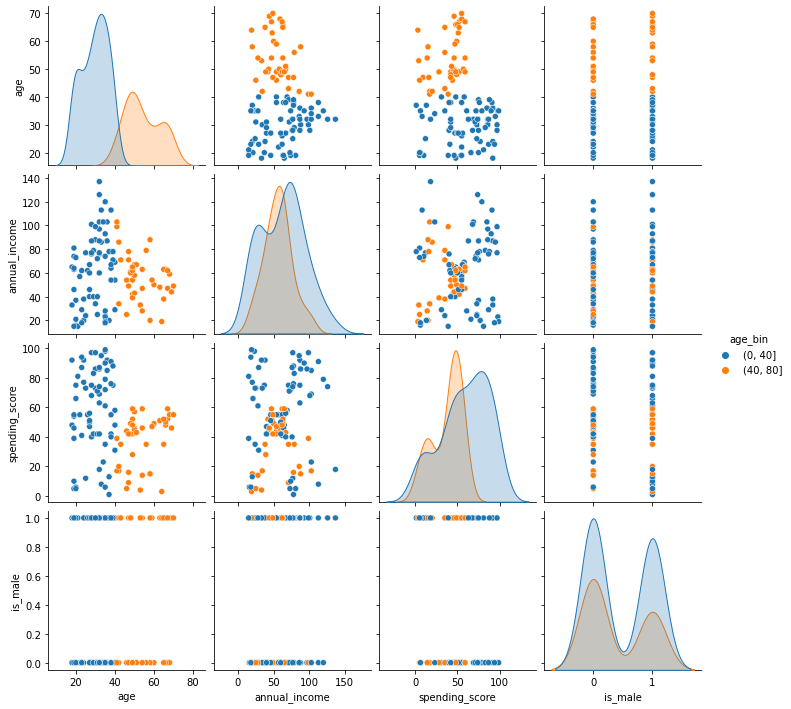

In [29]:
sns.pairplot(train, hue='age_bin')

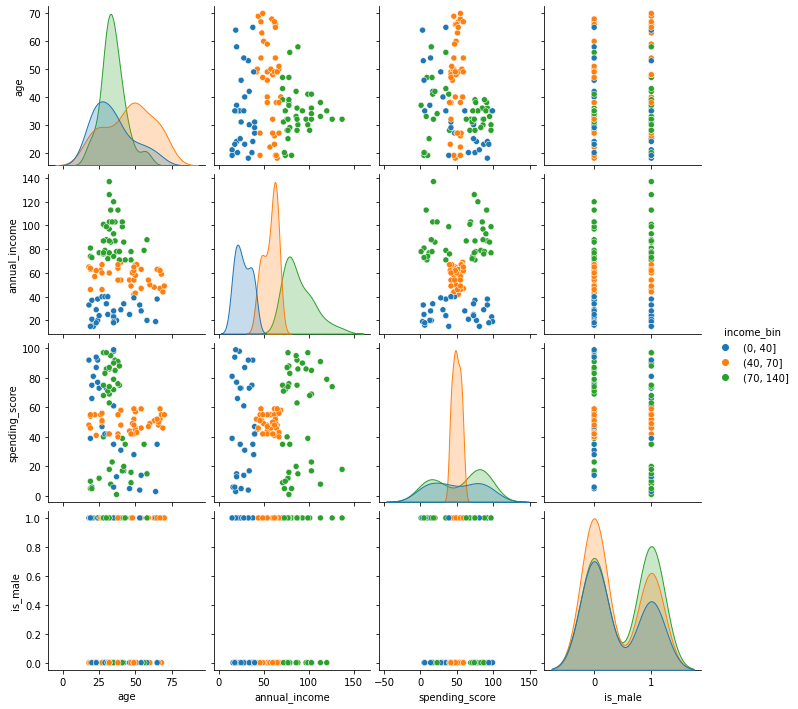

In [31]:
sns.pairplot(train, hue='income_bin')